# **California House Price Prediction** 

## **Business Problem Understanding**

### **Features**
The data pertains to the houses found in a given California district and some summary stats based
on the 1990 census data

- longitude: The longitude coordinate of the district.
- latitude: The latitude coordinate of the district.
- housing_median_age: The median age of houses in the district.
- total_rooms: The total number of rooms in the district.
- total_bedrooms: The total number of bedrooms in the district (with some missing values).
- population: The total population in the district.
- households: The total number of households in the district.
- median_income: The median income of households in the district.
- ocean_proximity: The proximity of the district to the ocean (categorical variable).
- median_house_value: The target variable, which is the median house value in the district.

**Key dataset statistics**:

- Number of rows: 14,448
- Number of non-null values in the "total_bedrooms" column: 14,311 (some missing values)
- Data types: The majority of columns are of type float64, and "ocean_proximity" is of type object (categorical).

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

# test split
from sklearn.model_selection import train_test_split

# preprocessing
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Cross Validation Algorithms
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR

# cross validation 
from sklearn.model_selection import cross_val_score

In [2]:
df = pd.read_csv('data_california_house.csv')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_house_value
0,-119.79,36.73,52.0,112.0,28.0,193.0,40.0,1.9750,INLAND,47500.0
1,-122.21,37.77,43.0,1017.0,328.0,836.0,277.0,2.2604,NEAR BAY,100000.0
2,-118.04,33.87,17.0,2358.0,396.0,1387.0,364.0,6.2990,<1H OCEAN,285800.0
3,-118.28,34.06,17.0,2518.0,1196.0,3051.0,1000.0,1.7199,<1H OCEAN,175000.0
4,-119.81,36.73,50.0,772.0,194.0,606.0,167.0,2.2206,INLAND,59200.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14448 entries, 0 to 14447
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           14448 non-null  float64
 1   latitude            14448 non-null  float64
 2   housing_median_age  14448 non-null  float64
 3   total_rooms         14448 non-null  float64
 4   total_bedrooms      14311 non-null  float64
 5   population          14448 non-null  float64
 6   households          14448 non-null  float64
 7   median_income       14448 non-null  float64
 8   ocean_proximity     14448 non-null  object 
 9   median_house_value  14448 non-null  float64
dtypes: float64(9), object(1)
memory usage: 1.1+ MB


### **Handling Missing Values**

In [4]:
# CHECK MISSING VALUE
df.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        137
population              0
households              0
median_income           0
ocean_proximity         0
median_house_value      0
dtype: int64

In [5]:
# CHECK DUPLICATE DATAS
df.duplicated().sum()

0

### **EDA**

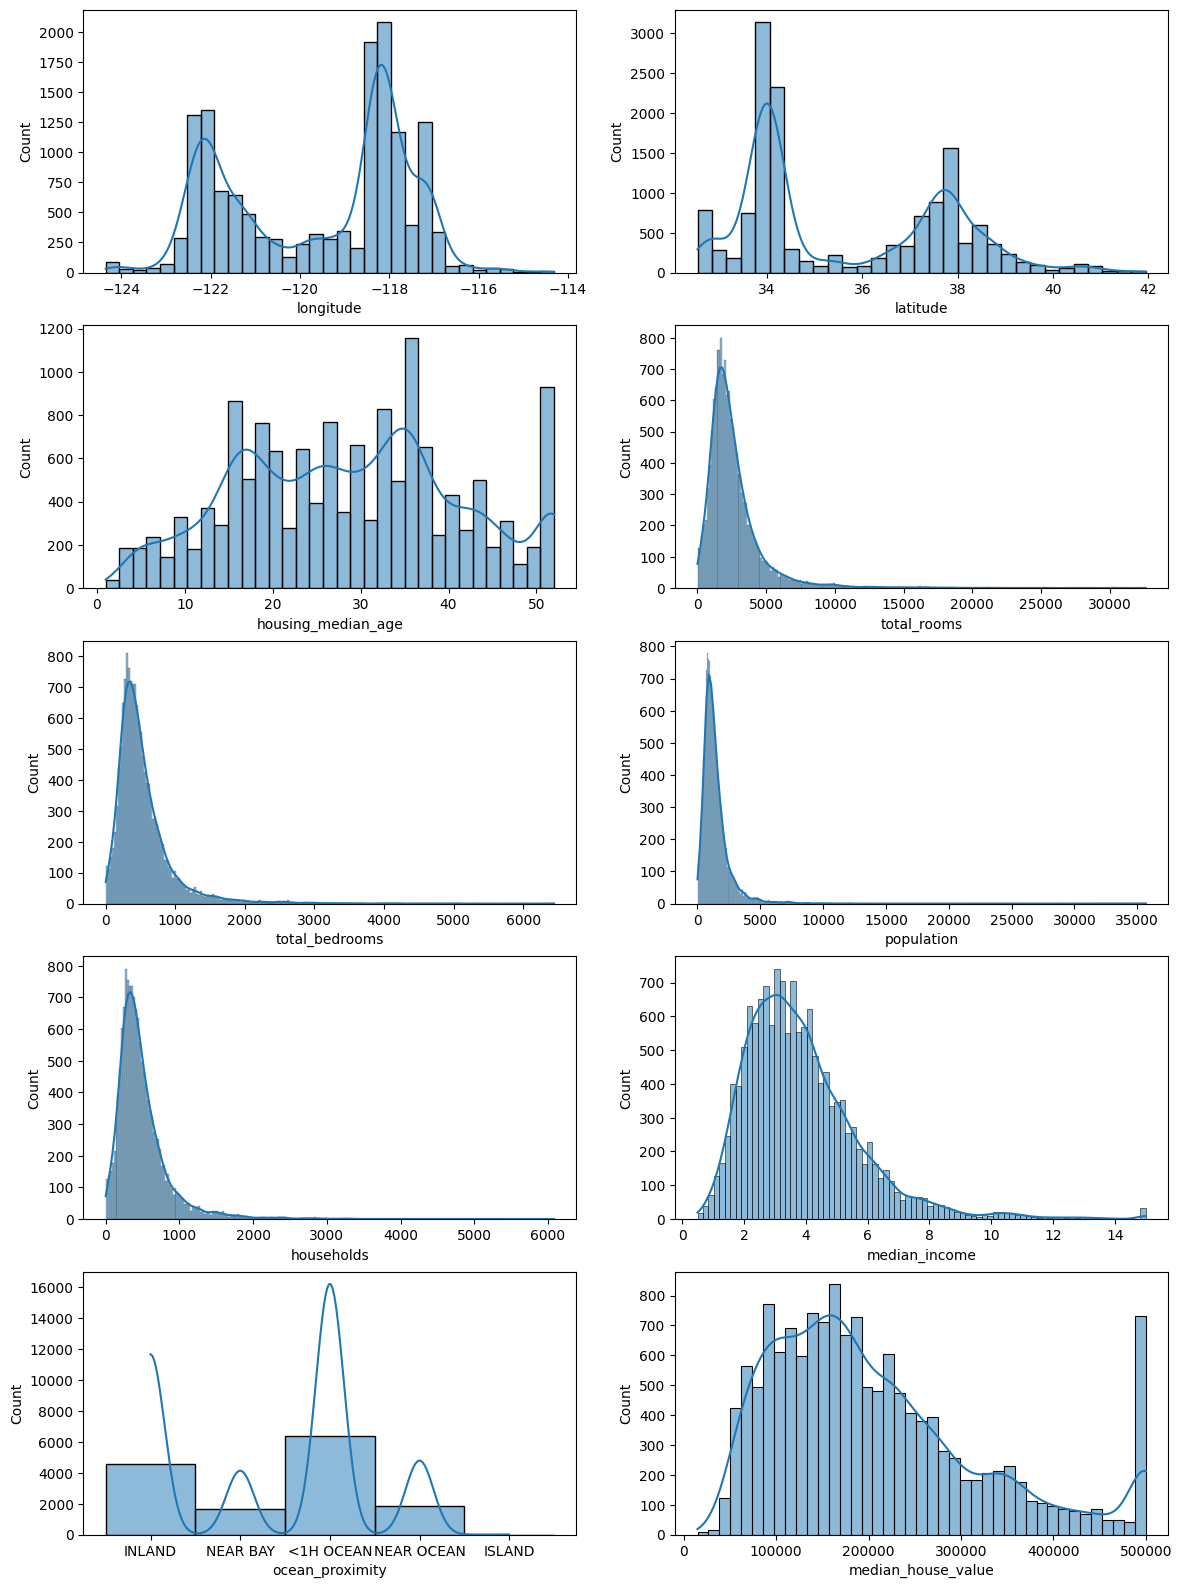

In [6]:
plt.figure(figsize=(14,28))
pltnum = 1
for column in df.describe(exclude=int).columns:
    plt.subplot(7,2,pltnum)
    sns.histplot(data=df, x=column, kde=True)
    pltnum += 1

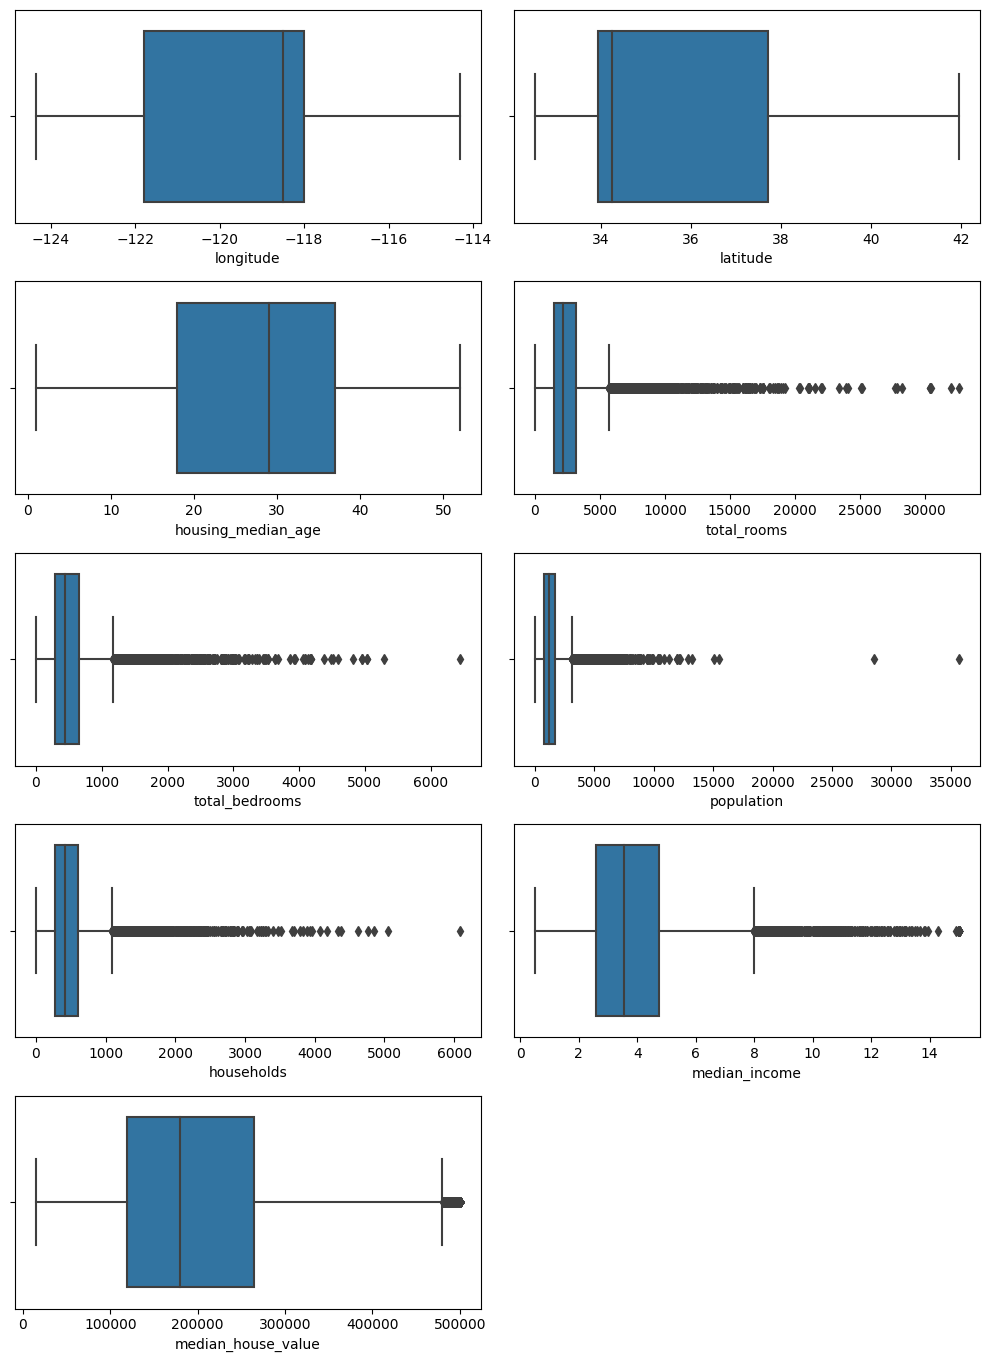

In [7]:
plt.figure(figsize=(10,16))
pltnum = 1
# filter columns that are numeric 
num_cols = df.select_dtypes(include=['int', 'float']).columns

for column in num_cols:
    plt.subplot(6,2,pltnum)
    sns.boxplot(data=df, x=column)
    pltnum += 1
    
plt.tight_layout()
plt.show()

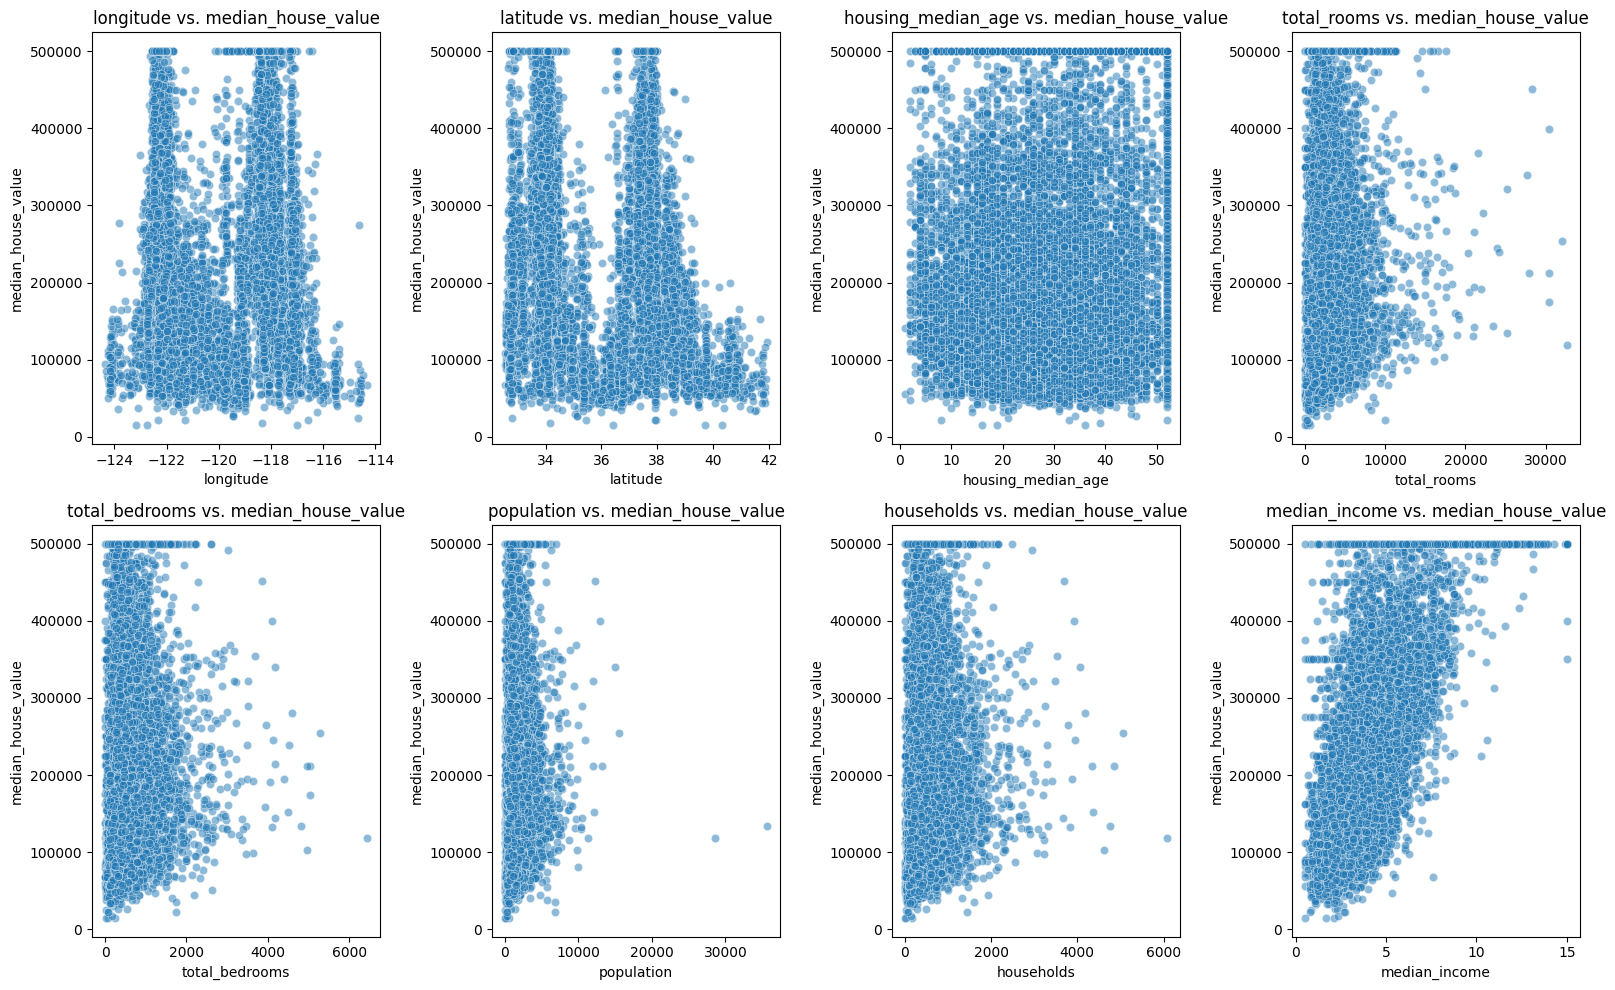

In [8]:
# List of features you want to visualize
features = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", "median_income"]

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 10))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Create scatterplots for each feature against the target variable
for i, feature in enumerate(features):
    sns.scatterplot(data=df, x=feature, y="median_house_value", ax=axes[i], alpha=0.5)
    axes[i].set_title(f"{feature} vs. median_house_value")
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel("median_house_value")

# Adjust layout and display
plt.tight_layout()
plt.show()


### **Data Splitting**

In [9]:
# Define X and y value
X = df.drop(columns=['median_house_value'])
y = df['median_house_value']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)

In [10]:
df.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity', 'median_house_value'],
      dtype='object')

### **Preprocessing**

In [11]:
# Create pipelines for scaling
std_pipe = Pipeline([
    ('std_scaler', StandardScaler())
])

rbst_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('rbst_scaler', RobustScaler())
])

# Select numerical columns excluding 'longitude', 'latitude', and 'housing_median_age'
rbst_num_attribs = df.select_dtypes(include=['number']).columns.difference(['longitude', 'latitude', 'housing_median_age', 'median_house_value'])
std_attribs = ['longitude', 'latitude', 'housing_median_age']
cat_attribs = ['ocean_proximity']

# Define the ColumnTransformer
transformer = ColumnTransformer([
    ('num_rbst_pipe', rbst_pipe, rbst_num_attribs),
    ('num_std_pipe', std_pipe, std_attribs),
    ('onehot', OneHotEncoder(), cat_attribs)
], remainder='passthrough')

transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('num_rbst_pipe',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('rbst_scaler',
                                                  RobustScaler())]),
                                 Index(['households', 'median_income', 'population', 'total_bedrooms',
       'total_rooms'],
      dtype='object')),
                                ('num_std_pipe',
                                 Pipeline(steps=[('std_scaler',
                                                  StandardScaler())]),
                                 ['longitude', 'latitude',
                                  'housing_median_age']),
                                ('onehot', OneHotEncoder(),
                                 ['ocean_proximity'])])

In [12]:
# Fit the ColumnTransformer to your training data
transformer.fit(X_train)

# Transform your training data
X_train_transformed = transformer.transform(X_train)

# Transform your test data using the same transformer
X_test_transformed = transformer.transform(X_test)

### **Cross Validation**

In [13]:

from sklearn.metrics import mean_squared_error

# Define the algorithms
tree = DecisionTreeRegressor(max_depth=5, random_state=0)
rf = RandomForestRegressor(random_state=0)
svr = SVR()
linreg = LinearRegression()
ridge = Ridge(alpha=1)
lasso = Lasso(alpha=1)

# Cross-validation
list_algo = [tree, rf, svr, linreg, ridge, lasso]
list_rmse_all = []
list_rmse_mean = []
list_rmse_std = []

for algo in list_algo:
    # Create the pipeline
    pipe_model = Pipeline([
        ('preprocessing', transformer),  # Assuming you've defined 'transformer' elsewhere
        ('modeling', algo)
    ])
    
    # CV score with negative MSE
    model_cv = cross_val_score(
        estimator=pipe_model,
        X=X_train,
        y=y_train,
        cv=5,
        scoring='neg_mean_squared_error'  # Use negative MSE
    )
    
    # Calculate RMSE (positive values)
    list_rmse = np.sqrt(-model_cv)  # Convert negative MSE to positive RMSE
    list_rmse_all.append(list_rmse.round(2))
    list_rmse_mean.append(list_rmse.mean())
    list_rmse_std.append(list_rmse.std())

df_model_cv = pd.DataFrame({
    'algo': list_algo,
    'rmse_all': list_rmse_all,
    'rmse_mean': list_rmse_mean,
    'rmse_std': list_rmse_std
})
df_model_cv


c:\Users\valou\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.550e+12, tolerance: 1.221e+10
  model = cd_fast.enet_coordinate_descent(
c:\Users\valou\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.643e+12, tolerance: 1.248e+10
  model = cd_fast.enet_coordinate_descent(
c:\Users\valou\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

,algo,rmse_all,rmse_mean,rmse_std
0,"DecisionTreeRegressor(max_depth=5, random_stat...","[72596.28, 68231.46, 69816.9, 71183.54, 73178.44]",71001.322159,1810.631036
1,RandomForestRegressor(random_state=0),"[52125.36, 49869.99, 49333.81, 49747.95, 53136...",50842.785261,1505.295021
2,SVR(),"[122204.77, 115648.8, 116063.57, 118298.65, 12...",118532.604535,2514.668839
3,LinearRegression(),"[71960.86, 66987.7, 67235.4, 68293.8, 70249.9]",68945.532994,1896.099306
4,Ridge(alpha=1),"[71959.21, 66967.39, 67264.77, 68292.19, 70250...",68946.758413,1894.693211
5,Lasso(alpha=1),"[71960.68, 66983.09, 67240.78, 68293.72, 70249...",68945.601873,1896.011789


### **Hyperparameter Tuning**

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

model_pipe = Pipeline([
    ('preprocessing', transformer),
    ('model', rf)
])

# Define the parameter grid
# param_grid = {
#     'model_n_estimators': [100, 200, 300],
#     'model_max_depth': [5, 10, 20],
#     'model_min_samples_split': [2, 5, 10],
#     'model_min_samples_leaf': [1, 2, 4]
# }

# # Create the GridSearchCV object
# gridsearch = GridSearchCV(
#     estimator=rf,  # Use rf as the estimator, not model_pipe
#     param_grid=param_grid,
#     cv=5,
#     scoring='neg_mean_squared_error'
# )

# Define the parameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=100,
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=0
)


random_search

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=0),
                   n_iter=100,
                   param_distributions={'max_depth': [5, 10, 20],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300]},
                   random_state=0, scoring='neg_mean_squared_error')

In [15]:
# Fit the RandomizedSearchCV to the training data
random_search.fit(X_train_transformed, y_train)

c:\Users\valou\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 81 is smaller than n_iter=100. Running 81 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=0),
                   n_iter=100,
                   param_distributions={'max_depth': [5, 10, 20],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300]},
                   random_state=0, scoring='neg_mean_squared_error')

In [16]:
# Retrive the Best Hyperparams
best_params = random_search.best_params_
best_score = random_search.best_score_

best_estimator = random_search.best_estimator_

In [17]:
test_predictions = best_estimator.predict(X_test_transformed)
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))


### **Before Tuning**

In [18]:
from sklearn.metrics import mean_squared_error, r2_score

rf.fit(X_train_transformed, y_train)

# Make predictions on the test set using the model before tuning
y_pred_before_tuning = rf.predict(X_test_transformed)

# Calculate MSE and RMSE before tuning
mse_before_tuning = mean_squared_error(y_test, y_pred_before_tuning)
rmse_before_tuning = np.sqrt(mse_before_tuning)

# Calculate R-squared (R^2) before tuning
r2_before_tuning = r2_score(y_test, y_pred_before_tuning)

print("Before Hyperparameter Tuning:")
print("Mean Squared Error (MSE):", mse_before_tuning)
print("Root Mean Squared Error (RMSE):", rmse_before_tuning)
print("R-squared (R^2):", r2_before_tuning)


Before Hyperparameter Tuning:
Mean Squared Error (MSE): 2528736568.1907897
Root Mean Squared Error (RMSE): 50286.54460380818
R-squared (R^2): 0.8057613808519187


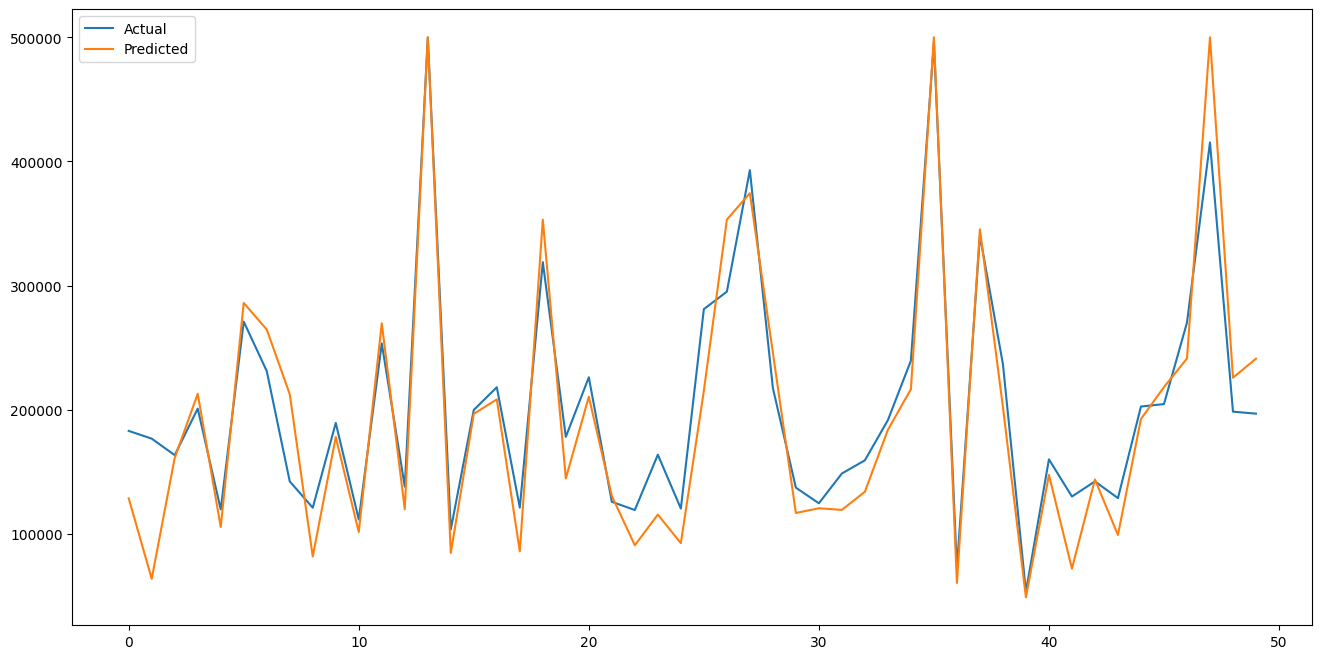

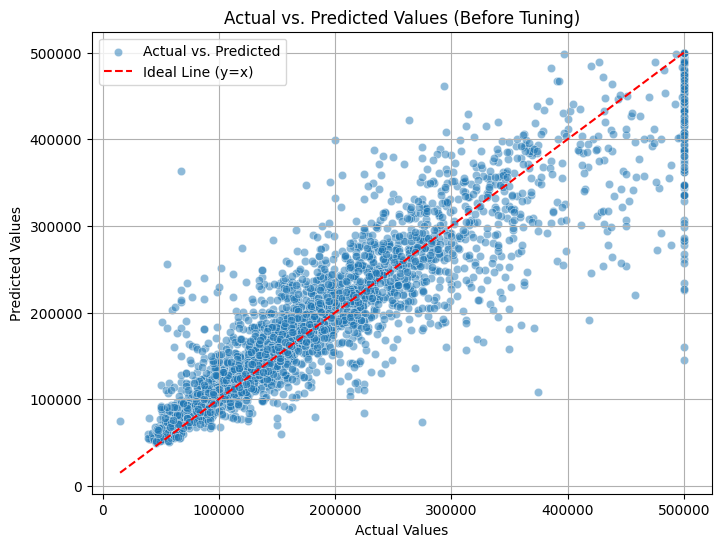

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


import seaborn as sns
import matplotlib.pyplot as plt

# Create a DataFrame with 'Predicted' and 'Actual' columns
test = pd.DataFrame({'Predicted': y_pred_before_tuning, 'Actual': y_test})

# Reset the index and drop the 'index' column
test = test.reset_index()
test = test.drop(['index'], axis=1)

# Create a line plot for the first 50 data points
plt.figure(figsize=(16, 8))
plt.plot(test[:50])
plt.legend(['Actual', 'Predicted'])

# Create an array of evenly spaced values for the ideal y=x line
ideal_line = np.linspace(min(y_test), max(y_test), len(y_test))

# Create a scatter plot with Seaborn
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_before_tuning, alpha=0.5, label='Actual vs. Predicted')

# Plot the ideal line (y=x) using Seaborn
sns.lineplot(x=ideal_line, y=ideal_line, color='red', linestyle='--', label='Ideal Line (y=x)')

plt.title('Actual vs. Predicted Values (Before Tuning)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.show()


In [20]:
# Get the best parameters and best estimator from the search
best_params = random_search.best_params_
best_estimator = random_search.best_estimator_

# Make predictions on the test set using the tuned model (best_estimator)
y_pred_after_tuning = best_estimator.predict(X_test_transformed)

# Calculate MSE and RMSE after tuning
mse_after_tuning = mean_squared_error(y_test, y_pred_after_tuning)
rmse_after_tuning = np.sqrt(mse_after_tuning)

# Calculate R-squared (R^2) after tuning
r2_after_tuning = r2_score(y_test, y_pred_after_tuning)

print("After Hyperparameter Tuning:")
print("Best Parameters:", best_params)
print("Mean Squared Error (MSE):", mse_after_tuning)
print("Root Mean Squared Error (RMSE):", rmse_after_tuning)
print("R-squared (R^2):", r2_after_tuning)


After Hyperparameter Tuning:
Best Parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 20}
Mean Squared Error (MSE): 2536868289.4276533
Root Mean Squared Error (RMSE): 50367.33355487119
R-squared (R^2): 0.8051367628809469


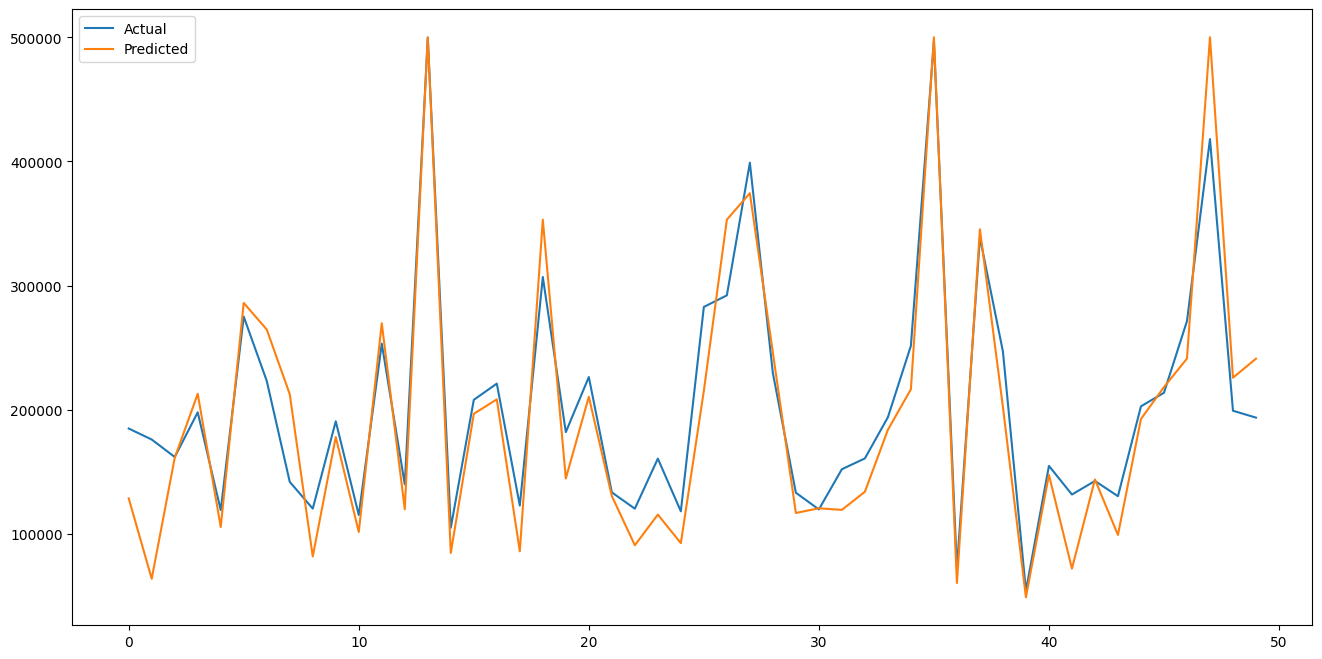

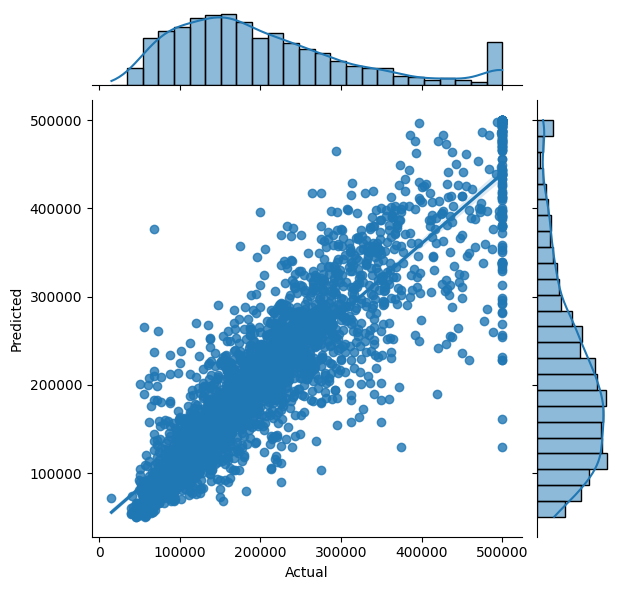

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a DataFrame with 'Predicted' and 'Actual' columns after tuning
test_after_tuning = pd.DataFrame({'Predicted': y_pred_after_tuning, 'Actual': y_test})

# Reset the index and drop the 'index' column
test_after_tuning = test_after_tuning.reset_index()
test_after_tuning = test_after_tuning.drop(['index'], axis=1)

# Create a line plot for the first 50 data points after tuning
plt.figure(figsize=(16, 8))
plt.plot(test_after_tuning[:50])
plt.legend(['Actual', 'Predicted'])

# Create a jointplot with regression line after tuning
sns.jointplot(x='Actual', y='Predicted', data=test_after_tuning, kind="reg")

plt.show()
